# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.seasonal import STL

# Fake Signal

In [ ]:
class SignalGenerator:
    def __init__(self, duration=10, sampling_rate=100):
        self.duration = duration
        self.sampling_rate = sampling_rate
        self.n_samples = int(duration * sampling_rate)
        self.t = np.linspace(0, duration, self.n_samples)

    def signal_1(self, frequency=1, amplitude=1, noise_level=0.1):
        clean_signal = amplitude * np.sin(2 * np.pi * frequency * self.t)
        noise = np.random.normal(0, noise_level, len(self.t))
        return clean_signal + noise

    def signal_2(self, step_size=0.1):
        steps = np.random.normal(0, step_size, len(self.t))
        return np.cumsum(steps)

    def signal_3(self, step_size=0.1):
        steps = np.random.normal(0, step_size, len(self.t))
        return np.cumsum(steps)

    def signal_4(self, step_size=0.1):
        steps = np.random.normal(0, step_size, len(self.t))
        return np.cumsum(steps)

In [ ]:
sg = SignalGenerator(duration=10, sampling_rate=100)

Text(0.5, 0, 'Time (seconds)')

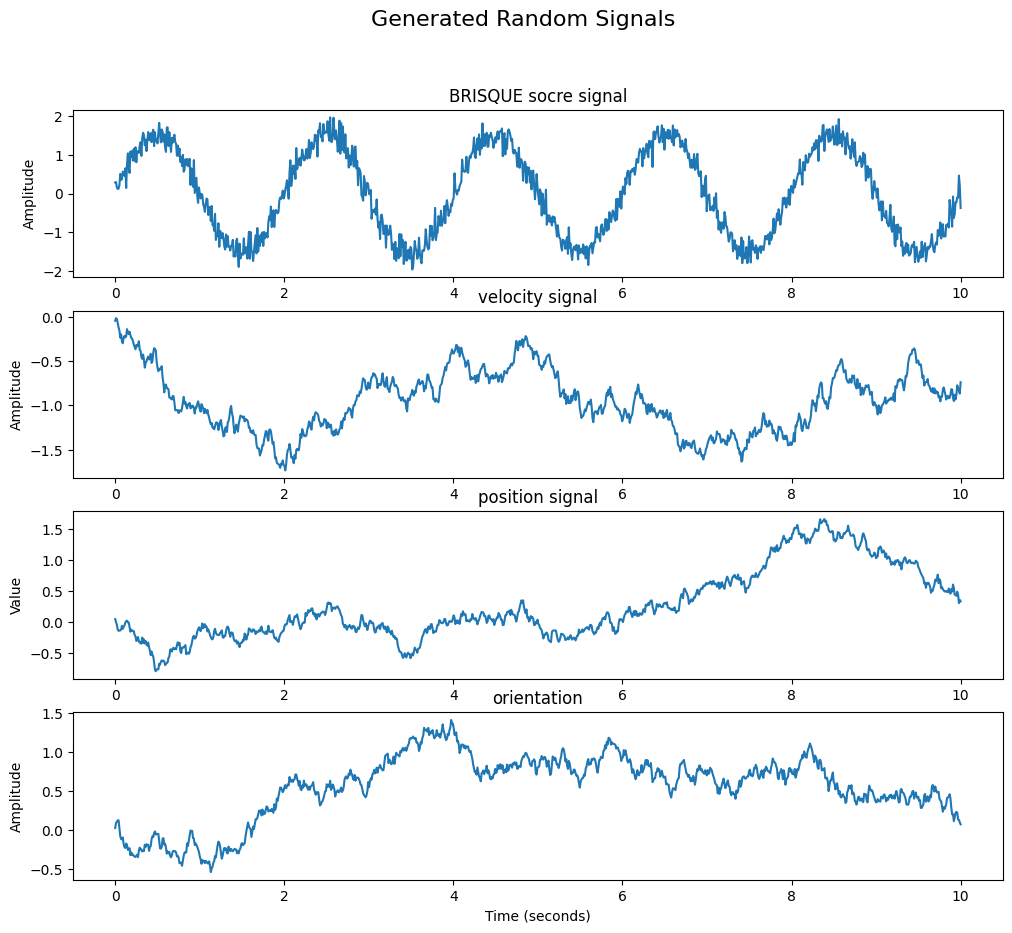

In [ ]:
# Create figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
fig.suptitle('Generated Random Signals', fontsize=16)

# Generate and plot signals
# 1. Sinusoidal signal
sin_signal = sg.signal_1(frequency=0.5, amplitude=1.5, noise_level=0.2)
axes[0].plot(sg.t, sin_signal)
axes[0].set_title('BRISQUE socre signal')
axes[0].set_ylabel('Amplitude')

# 2. Chirp signal
chirp_signal = sg.signal_2(step_size=0.05)
axes[1].plot(sg.t, chirp_signal)
axes[1].set_title('velocity signal')
axes[1].set_ylabel('Amplitude')

# 3. Random walk
random_walk = sg.signal_3(step_size=0.05)
axes[2].plot(sg.t, random_walk)
axes[2].set_title('position signal')
axes[2].set_ylabel('Value')

# 4. Square pulse
square_signal = sg.signal_4(step_size=0.05)
axes[3].plot(sg.t, square_signal)
axes[3].set_title('orientation')
axes[3].set_ylabel('Amplitude')
axes[3].set_xlabel('Time (seconds)')

In [ ]:
sin_signal = sg.signal_1(frequency=0.5, amplitude=1.5, noise_level=0.2)
chirp_signal = sg.signal_2(step_size=0.1)
random_walk = sg.signal_3(step_size=0.05)
square_signal = sg.signal_4(step_size=0.2)

# Stack the signals into a [4, 100] array
signals_array = np.vstack([sin_signal, chirp_signal, random_walk, square_signal])

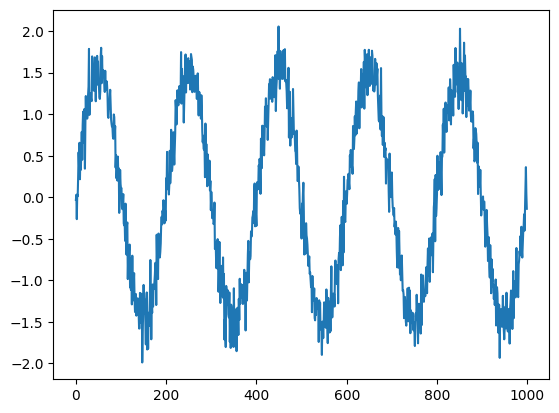

In [ ]:
plt.plot(signals_array[0])

In [ ]:
signals_array.shape

(4, 1000)

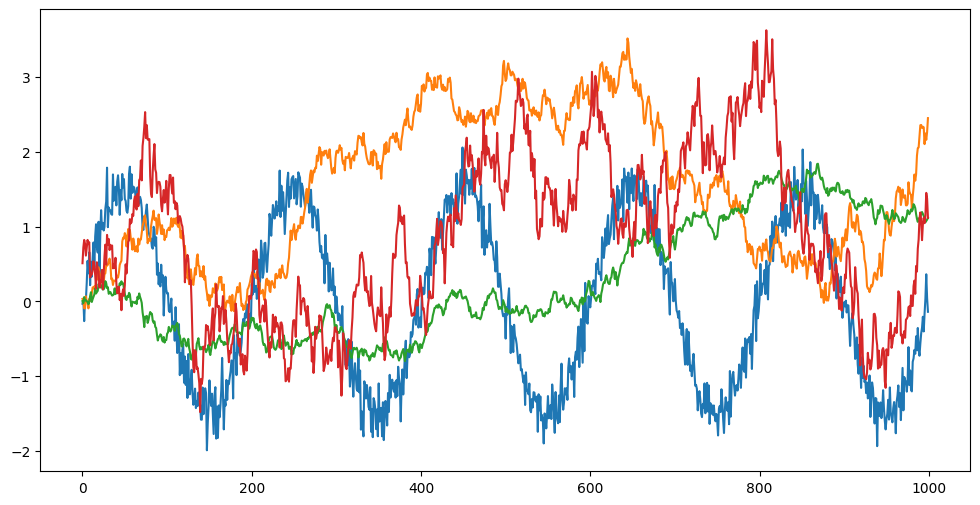

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(signals_array.T);

# Applying method

In [ ]:
sample = np.random.randn(4, 4, 1000)
anomal_signal = signals_array.reshape(1, 4, -1)

sample = np.vstack([sample, anomal_signal])
sample[-1].shape

(4, 1000)

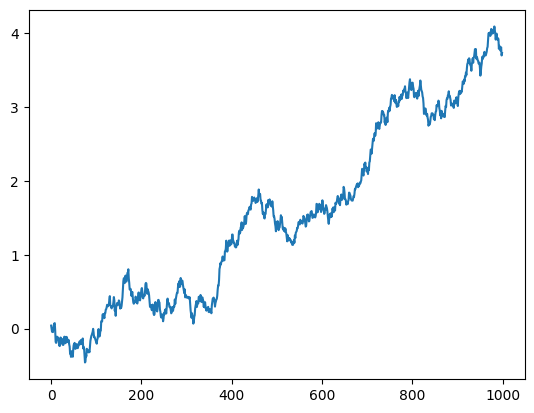

In [ ]:
plt.plot(sample[-1, 2].T);

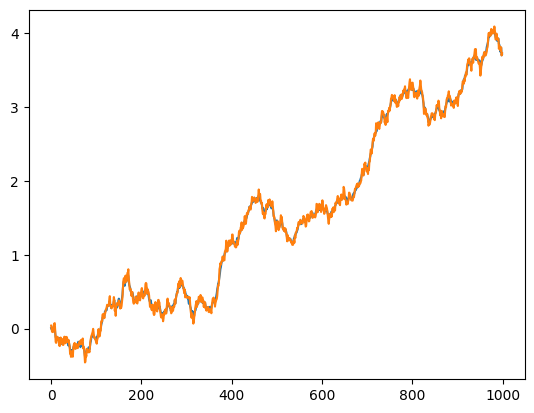

In [ ]:
stl = STL(sample[-1, 2], period = 10)
res = stl.fit()
plt.plot(res.trend + res.seasonal)
plt.plot(sample[-1, 2].T)

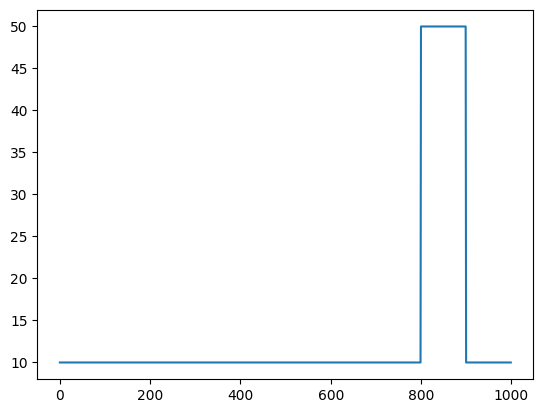

In [ ]:
anomal_signal = np.ones((1, 4, 1000)) * 10
anomal_signal[0, :, 800:900] = 50

plt.plot(anomal_signal[0,0,:]);


In [ ]:
sample = np.random.randn(4, 4, 1000)
anomal_signal = np.ones((1, 4, 1000)) * 50

# anomal_signal[0, :, 2:900] = 50

sample = np.vstack([sample, anomal_signal])

class RobotAnomalyDetector(nn.Module):
    def __init__(self, n_robots, n_sensors):
        super(RobotAnomalyDetector, self).__init__()
        self.detector = OneClassSVM(kernel='rbf', nu=0.7)
        self.scaler = StandardScaler()
        self.n_robots = n_robots
        self.n_sensors = n_sensors

    def prepare_robot_features(self, robot_signals):
        """
        Extract features from each robot's sensor signals

        Parameters:
        robot_signals: array of shape (n_robots, n_sensors, n_timestamps)

        Returns:
        features: array of shape (n_robots, n_features)
        """
        robot_signals_copy = robot_signals.copy()
        features_list = []
        features_list.append(robot_signals_copy.mean(axis=-1))
        features_list.append(robot_signals_copy.std(axis=-1))
        features_list.append(robot_signals_copy.max(axis=-1))
        features_list.append(robot_signals_copy.min(axis=-1))
        features_list.append(np.median(robot_signals_copy, axis=-1))
        features_list.append(np.percentile(robot_signals_copy, 25, axis=-1))
        features_list.append(np.percentile(robot_signals_copy, 75, axis=-1))
        features_list.append(np.quantile(robot_signals_copy, 0.9, axis=-1))
        features_list.append(np.quantile(robot_signals_copy, 0.1, axis=-1))


        # feature_list shape -> (n_features, n_robots, n_sensors)
        # output -> (n_robots, n_sensors, n_features)
        return (np.array(features_list).transpose(1, 2, 0))

    def SVM_with_features(self, robot_signals):
        features = self.prepare_robot_features(robot_signals)
        anomaly_socres = []
        for i in range(self.n_sensors):
            scaled_feature = self.scaler.fit_transform(features[:, i, :])
            anomaly_classes = self.detector.fit_predict(scaled_feature)
            anomaly_socres.append(self.detector.score_samples(scaled_feature))
        return np.array(anomaly_socres).sum(axis = 0)

    def SVM_without_features(self, robot_signals):
        anomalies_socre = []

        for i in range(self.n_sensors):
            scaled_feature = self.scaler.fit_transform(robot_signals[:, i, :])
            anomalies_class = self.detector.fit_predict(scaled_feature)
            anomalies_socre.append(self.detector.score_samples(scaled_feature))


        return np.array(anomalies_socre).sum(axis = 0)

    def moving_average(self, signal, window_size=10, threshold=0.7):
        # Calculate moving average

        ma = np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

        # Pad the MA to match original signal length
        pad_size = len(signal) - len(ma)
        ma = np.pad(ma, (pad_size, 0), mode='edge')

        # Calculate deviation from MA
        deviation = np.abs(signal - ma)

        # Detect anomalies where deviation exceeds threshold * std
        threshold = threshold * np.std(deviation)
        anomalies = deviation > threshold

        return anomalies

    def moving_average_detector(self, robot_signals):
        anomalies_socre = []

        for i in range(self.n_robots):
            anomaly_counter = 0
            for j in range(self.n_sensors):
                anomaly_counter += (self.moving_average(robot_signals[i, j, :])).sum()
            anomalies_socre.append(anomaly_counter)

        return anomalies_socre





print(sample.shape)


rad = RobotAnomalyDetector(n_robots=5, n_sensors=4)
anomaly_scores = rad.SVM_with_features(sample)

anomaly_scores

(5, 4, 1000)


array([ 9.99930955,  9.99704093,  9.99522959, 10.00020699,  4.0194087 ])

In [ ]:
anomaly_scores = rad.SVM_without_features(sample)
anomaly_scores

array([9.97136819, 9.97051646, 9.97053041, 9.97143647, 4.01944092])

In [ ]:
anomaly_scores = rad.SVM_with_features(sample)
anomaly_scores

array([ 9.99930955,  9.99704093,  9.99522959, 10.00020699,  4.0194087 ])

In [ ]:
anomaly_scores = rad.moving_average_detector(sample)
anomaly_scores

[2706, 2665, 2668, 2639, 0]